# Method 5 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

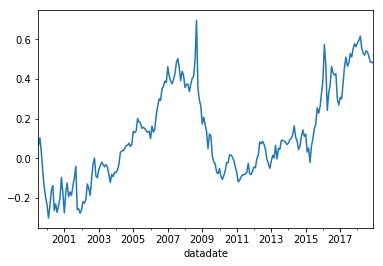

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.195748
2000-12-31    0.027523
2001-12-31   -0.123903
2002-12-31    0.247356
2003-12-31    0.030107
2004-12-31    0.152228
2005-12-31    0.061500
2006-12-31    0.215177
2007-12-31    0.026432
2008-12-31   -0.109196
2009-12-31   -0.270188
2010-12-31    0.037384
2011-12-31   -0.022070
2012-12-31    0.015176
2013-12-31    0.125432
2014-12-31    0.039477
2015-12-31    0.197510
2016-12-31   -0.046369
2017-12-31    0.231291
2018-12-31   -0.052830
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     16.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.05e-12
Time:                        04:37:40   Log-Likelihood:                 399.34
No. Observations:                 234   AIC:                            -788.7
Df Residuals:                     229   BIC:                            -771.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.385      0.701      -0.005       0.007
mktrf         -0.0542      0.083     -0.654      0.513      -0.217       0.109
me            -0.1705      0.096     -1.770      0.078      -0.360       0.019
ia             0.3965      0.146      2.709      0.007       0.108       0.685
roe            0.5178      0.125      4.133      0.000       0.271       0.765
==============================================================================
Omnibus:                       85.270   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.557
Skew:                          -1.353   Prob(JB):                     1.18e-94
Kurtosis:                       9.087   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     12.32
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.32e-09
Time:                        04:37:40   Log-Likelihood:                 399.34
No. Observations:                 234   AIC:                            -788.7
Df Residuals:                     229   BIC:                            -771.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.378      0.705      -0.005       0.007
mktrf         -0.0542      0.142     -0.382      0.703      -0.332       0.224
me            -0.1705      0.107     -1.596      0.110      -0.380       0.039
ia             0.3965      0.207      1.912      0.056      -0.010       0.803
roe            0.5178      0.128      4.030      0.000       0.266       0.770
==============================================================================
Omnibus:                       85.270   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.557
Skew:                          -1.353   Prob(JB):                     1.18e-94
Kurtosis:                       9.087   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     11.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.16e-08
Time:                        04:37:40   Log-Likelihood:                 399.34
No. Observations:                 234   AIC:                            -788.7
Df Residuals:                     229   BIC:                            -771.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.352      0.725      -0.005       0.008
mktrf         -0.0542      0.139     -0.390      0.696      -0.326       0.218
me            -0.1705      0.113     -1.510      0.131      -0.392       0.051
ia             0.3965      0.235      1.686      0.092      -0.064       0.858
roe            0.5178      0.141      3.684      0.000       0.242       0.793
==============================================================================
Omnibus:                       85.270   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.557
Skew:                          -1.353   Prob(JB):                     1.18e-94
Kurtosis:                       9.087   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     16.22
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.12e-13
Time:                        04:37:40   Log-Likelihood:                 405.19
No. Observations:                 234   AIC:                            -798.4
Df Residuals:                     228   BIC:                            -777.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.270      0.788      -0.005       0.007
mktrf         -0.0786      0.081     -0.970      0.333      -0.238       0.081
smb           -0.1386      0.107     -1.295      0.196      -0.349       0.072
hml            0.1528      0.126      1.211      0.227      -0.096       0.401
rmw            0.6131      0.143      4.299      0.000       0.332       0.894
cma            0.0748      0.181      0.412      0.680      -0.282       0.432
==============================================================================
Omnibus:                       75.264   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.543
Skew:                          -1.210   Prob(JB):                     1.86e-74
Kurtosis:                       8.382   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     30.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.31e-24
Time:                        04:37:40   Log-Likelihood:                 405.19
No. Observations:                 234   AIC:                            -798.4
Df Residuals:                     228   BIC:                            -777.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.261      0.794      -0.005       0.007
mktrf         -0.0786      0.096     -0.823      0.411      -0.266       0.109
smb           -0.1386      0.126     -1.103      0.270      -0.385       0.108
hml            0.1528      0.235      0.650      0.516      -0.308       0.613
rmw            0.6131      0.143      4.286      0.000       0.333       0.894
cma            0.0748      0.205      0.365      0.715      -0.326       0.476
==============================================================================
Omnibus:                       75.264   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.543
Skew:                          -1.210   Prob(JB):                     1.86e-74
Kurtosis:                       8.382   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     31.83
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-24
Time:                        04:37:40   Log-Likelihood:                 405.19
No. Observations:                 234   AIC:                            -798.4
Df Residuals:                     228   BIC:                            -777.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.246      0.806      -0.006       0.007
mktrf         -0.0786      0.093     -0.842      0.400      -0.262       0.104
smb           -0.1386      0.139     -0.995      0.320      -0.412       0.134
hml            0.1528      0.234      0.654      0.513      -0.305       0.611
rmw            0.6131      0.152      4.031      0.000       0.315       0.911
cma            0.0748      0.187      0.399      0.690      -0.292       0.442
==============================================================================
Omnibus:                       75.264   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.543
Skew:                          -1.210   Prob(JB):                     1.86e-74
Kurtosis:                       8.382   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     17.91
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.26e-13
Time:                        04:37:40   Log-Likelihood:                 401.44
No. Observations:                 234   AIC:                            -792.9
Df Residuals:                     229   BIC:                            -775.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.137      0.257      -0.002       0.009
mktrf         -0.1596      0.076     -2.112      0.036      -0.308      -0.011
smb           -0.4322      0.094     -4.584      0.000      -0.618      -0.246
hml            0.3560      0.094      3.800      0.000       0.171       0.541
umd            0.1665      0.061      2.709      0.007       0.045       0.288
==============================================================================
Omnibus:                       73.529   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.163
Skew:                          -1.173   Prob(JB):                     1.01e-73
Kurtosis:                       8.383   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     9.541
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.76e-07
Time:                        04:37:40   Log-Likelihood:                 401.44
No. Observations:                 234   AIC:                            -792.9
Df Residuals:                     229   BIC:                            -775.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.179      0.238      -0.002       0.009
mktrf         -0.1596      0.121     -1.317      0.188      -0.397       0.078
smb           -0.4322      0.094     -4.614      0.000      -0.616      -0.249
hml            0.3560      0.176      2.026      0.043       0.012       0.700
umd            0.1665      0.072      2.303      0.021       0.025       0.308
==============================================================================
Omnibus:                       73.529   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.163
Skew:                          -1.173   Prob(JB):                     1.01e-73
Kurtosis:                       8.383   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.145
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-05
Time:                        04:37:40   Log-Likelihood:                 401.44
No. Observations:                 234   AIC:                            -792.9
Df Residuals:                     229   BIC:                            -775.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.116      0.264      -0.003       0.009
mktrf         -0.1596      0.122     -1.303      0.193      -0.400       0.080
smb           -0.4322      0.099     -4.346      0.000      -0.627      -0.237
hml            0.3560      0.195      1.828      0.068      -0.026       0.738
umd            0.1665      0.072      2.302      0.021       0.025       0.308
==============================================================================
Omnibus:                       73.529   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.163
Skew:                          -1.173   Prob(JB):                     1.01e-73
Kurtosis:                       8.383   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     12.01
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.47e-08
Time:                        04:37:40   Log-Likelihood:                 192.83
No. Observations:                 120   AIC:                            -375.7
Df Residuals:                     115   BIC:                            -361.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.005     -0.176      0.861      -0.010       0.009
mktrf          0.0616      0.128      0.482      0.631      -0.191       0.315
me            -0.1872      0.126     -1.483      0.141      -0.437       0.063
ia             0.8028      0.198      4.063      0.000       0.411       1.194
roe            0.4205      0.175      2.404      0.018       0.074       0.767
==============================================================================
Omnibus:                       51.548   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.564
Skew:                          -1.508   Prob(JB):                     1.38e-40
Kurtosis:                       8.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     22.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.78e-14
Time:                        04:37:40   Log-Likelihood:                 192.83
No. Observations:                 120   AIC:                            -375.7
Df Residuals:                     115   BIC:                            -361.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.187      0.851      -0.010       0.008
mktrf          0.0616      0.219      0.281      0.779      -0.368       0.491
me            -0.1872      0.140     -1.341      0.180      -0.461       0.086
ia             0.8028      0.237      3.393      0.001       0.339       1.266
roe            0.4205      0.151      2.777      0.005       0.124       0.717
==============================================================================
Omnibus:                       51.548   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.564
Skew:                          -1.508   Prob(JB):                     1.38e-40
Kurtosis:                       8.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     45.91
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.36e-23
Time:                        04:37:40   Log-Likelihood:                 192.83
No. Observations:                 120   AIC:                            -375.7
Df Residuals:                     115   BIC:                            -361.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.005     -0.172      0.863      -0.010       0.009
mktrf          0.0616      0.217      0.284      0.776      -0.363       0.487
me            -0.1872      0.145     -1.294      0.196      -0.471       0.096
ia             0.8028      0.230      3.484      0.000       0.351       1.254
roe            0.4205      0.147      2.852      0.004       0.132       0.709
==============================================================================
Omnibus:                       51.548   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.564
Skew:                          -1.508   Prob(JB):                     1.38e-40
Kurtosis:                       8.255   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     16.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.59e-12
Time:                        04:37:40   Log-Likelihood:                 204.42
No. Observations:                 120   AIC:                            -396.8
Df Residuals:                     114   BIC:                            -380.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.004     -0.243      0.808      -0.010       0.008
mktrf         -0.0664      0.123     -0.540      0.590      -0.310       0.177
smb           -0.2214      0.139     -1.591      0.114      -0.497       0.054
hml            0.6169      0.170      3.619      0.000       0.279       0.955
rmw            0.2461      0.201      1.224      0.223      -0.152       0.644
cma            0.1375      0.220      0.624      0.534      -0.299       0.574
==============================================================================
Omnibus:                       42.999   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.784
Skew:                          -1.246   Prob(JB):                     5.99e-32
Kurtosis:                       7.749   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     60.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.67e-30
Time:                        04:37:40   Log-Likelihood:                 204.42
No. Observations:                 120   AIC:                            -396.8
Df Residuals:                     114   BIC:                            -380.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.004     -0.250      0.803      -0.010       0.007
mktrf         -0.0664      0.143     -0.463      0.643      -0.347       0.215
smb           -0.2214      0.167     -1.324      0.185      -0.549       0.106
hml            0.6169      0.164      3.759      0.000       0.295       0.939
rmw            0.2461      0.158      1.556      0.120      -0.064       0.556
cma            0.1375      0.177      0.778      0.436      -0.209       0.484
==============================================================================
Omnibus:                       42.999   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.784
Skew:                          -1.246   Prob(JB):                     5.99e-32
Kurtosis:                       7.749   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     104.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.58e-41
Time:                        04:37:40   Log-Likelihood:                 204.42
No. Observations:                 120   AIC:                            -396.8
Df Residuals:                     114   BIC:                            -380.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.005     -0.226      0.821      -0.010       0.008
mktrf         -0.0664      0.140     -0.475      0.635      -0.340       0.207
smb           -0.2214      0.181     -1.226      0.220      -0.575       0.132
hml            0.6169      0.143      4.326      0.000       0.337       0.896
rmw            0.2461      0.171      1.442      0.149      -0.088       0.581
cma            0.1375      0.128      1.072      0.284      -0.114       0.389
==============================================================================
Omnibus:                       42.999   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.784
Skew:                          -1.246   Prob(JB):                     5.99e-32
Kurtosis:                       7.749   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     21.69
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.35e-13
Time:                        04:37:40   Log-Likelihood:                 205.63
No. Observations:                 120   AIC:                            -401.3
Df Residuals:                     115   BIC:                            -387.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.059      0.953      -0.008       0.009
mktrf         -0.0818      0.101     -0.809      0.420      -0.282       0.119
smb           -0.3597      0.115     -3.123      0.002      -0.588      -0.132
hml            0.7301      0.115      6.330      0.000       0.502       0.959
umd            0.1339      0.071      1.883      0.062      -0.007       0.275
==============================================================================
Omnibus:                       45.840   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.220
Skew:                          -1.302   Prob(JB):                     4.88e-37
Kurtosis:                       8.164   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     29.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.75e-17
Time:                        04:37:40   Log-Likelihood:                 205.63
No. Observations:                 120   AIC:                            -401.3
Df Residuals:                     115   BIC:                            -387.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.062      0.950      -0.007       0.008
mktrf         -0.0818      0.146     -0.561      0.575      -0.368       0.204
smb           -0.3597      0.121     -2.980      0.003      -0.596      -0.123
hml            0.7301      0.142      5.136      0.000       0.452       1.009
umd            0.1339      0.074      1.817      0.069      -0.011       0.278
==============================================================================
Omnibus:                       45.840   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.220
Skew:                          -1.302   Prob(JB):                     4.88e-37
Kurtosis:                       8.164   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     29.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.57e-17
Time:                        04:37:40   Log-Likelihood:                 205.63
No. Observations:                 120   AIC:                            -401.3
Df Residuals:                     115   BIC:                            -387.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.056      0.955      -0.008       0.009
mktrf         -0.0818      0.146     -0.560      0.575      -0.368       0.204
smb           -0.3597      0.129     -2.792      0.005      -0.612      -0.107
hml            0.7301      0.112      6.519      0.000       0.511       0.950
umd            0.1339      0.075      1.782      0.075      -0.013       0.281
==============================================================================
Omnibus:                       45.840   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.220
Skew:                          -1.302   Prob(JB):                     4.88e-37
Kurtosis:                       8.164   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.19e-07
Time:                        04:37:40   Log-Likelihood:                 223.73
No. Observations:                 114   AIC:                            -437.5
Df Residuals:                     109   BIC:                            -423.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.166      0.246      -0.003       0.011
mktrf         -0.2228      0.102     -2.179      0.031      -0.425      -0.020
me             0.0260      0.158      0.165      0.869      -0.287       0.339
ia            -0.3723      0.219     -1.700      0.092      -0.806       0.062
roe            0.8185      0.192      4.255      0.000       0.437       1.200
==============================================================================
Omnibus:                        2.638   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.218
Skew:                           0.175   Prob(JB):                        0.330
Kurtosis:                       3.587   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     9.124
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.14e-06
Time:                        04:37:41   Log-Likelihood:                 223.73
No. Observations:                 114   AIC:                            -437.5
Df Residuals:                     109   BIC:                            -423.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.367      0.172      -0.002       0.010
mktrf         -0.2228      0.085     -2.623      0.009      -0.389      -0.056
me             0.0260      0.195      0.133      0.894      -0.357       0.409
ia            -0.3723      0.231     -1.610      0.107      -0.825       0.081
roe            0.8185      0.328      2.497      0.013       0.176       1.461
==============================================================================
Omnibus:                        2.638   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.218
Skew:                           0.175   Prob(JB):                        0.330
Kurtosis:                       3.587   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     8.248
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.53e-06
Time:                        04:37:41   Log-Likelihood:                 223.73
No. Observations:                 114   AIC:                            -437.5
Df Residuals:                     109   BIC:                            -423.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      1.633      0.102      -0.001       0.009
mktrf         -0.2228      0.077     -2.891      0.004      -0.374      -0.072
me             0.0260      0.207      0.126      0.900      -0.380       0.432
ia            -0.3723      0.258     -1.443      0.149      -0.878       0.133
roe            0.8185      0.360      2.275      0.023       0.113       1.524
==============================================================================
Omnibus:                        2.638   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.218
Skew:                           0.175   Prob(JB):                        0.330
Kurtosis:                       3.587   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     10.82
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.87e-08
Time:                        04:37:41   Log-Likelihood:                 228.63
No. Observations:                 114   AIC:                            -445.3
Df Residuals:                     108   BIC:                            -428.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.297      0.198      -0.002       0.011
mktrf         -0.2169      0.094     -2.312      0.023      -0.403      -0.031
smb            0.0840      0.152      0.552      0.582      -0.218       0.386
hml           -0.6984      0.194     -3.596      0.000      -1.083      -0.313
rmw            0.6623      0.238      2.785      0.006       0.191       1.134
cma            0.1108      0.302      0.367      0.714      -0.488       0.709
==============================================================================
Omnibus:                        5.078   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                7.293
Skew:                          -0.022   Prob(JB):                       0.0261
Kurtosis:                       4.238   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     6.625
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.04e-05
Time:                        04:37:41   Log-Likelihood:                 228.63
No. Observations:                 114   AIC:                            -445.3
Df Residuals:                     108   BIC:                            -428.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.004      1.189      0.235      -0.003       0.011
mktrf         -0.2169      0.080     -2.720      0.007      -0.373      -0.061
smb            0.0840      0.124      0.676      0.499      -0.160       0.328
hml           -0.6984      0.155     -4.503      0.000      -1.002      -0.394
rmw            0.6623      0.312      2.120      0.034       0.050       1.275
cma            0.1108      0.256      0.432      0.665      -0.391       0.613
==============================================================================
Omnibus:                        5.078   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                7.293
Skew:                          -0.022   Prob(JB):                       0.0261
Kurtosis:                       4.238   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     5.195
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000260
Time:                        04:37:41   Log-Likelihood:                 228.63
No. Observations:                 114   AIC:                            -445.3
Df Residuals:                     108   BIC:                            -428.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.251      0.211      -0.002       0.011
mktrf         -0.2169      0.085     -2.565      0.010      -0.383      -0.051
smb            0.0840      0.128      0.656      0.512      -0.167       0.335
hml           -0.6984      0.172     -4.062      0.000      -1.035      -0.361
rmw            0.6623      0.323      2.049      0.040       0.029       1.296
cma            0.1108      0.281      0.394      0.694      -0.441       0.662
==============================================================================
Omnibus:                        5.078   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                7.293
Skew:                          -0.022   Prob(JB):                       0.0261
Kurtosis:                       4.238   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     11.95
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.34e-08
Time:                        04:37:41   Log-Likelihood:                 226.21
No. Observations:                 114   AIC:                            -442.4
Df Residuals:                     109   BIC:                            -428.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.003      1.465      0.146      -0.002       0.012
mktrf         -0.2380      0.095     -2.511      0.014      -0.426      -0.050
smb           -0.0729      0.148     -0.493      0.623      -0.366       0.220
hml           -0.6070      0.152     -3.988      0.000      -0.909      -0.305
umd            0.2173      0.115      1.892      0.061      -0.010       0.445
==============================================================================
Omnibus:                       12.016   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.277
Skew:                           0.231   Prob(JB):                     2.66e-07
Kurtosis:                       5.482   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     11.12
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.34e-07
Time:                        04:37:41   Log-Likelihood:                 226.21
No. Observations:                 114   AIC:                            -442.4
Df Residuals:                     109   BIC:                            -428.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.004      1.321      0.186      -0.002       0.012
mktrf         -0.2380      0.083     -2.860      0.004      -0.401      -0.075
smb           -0.0729      0.120     -0.607      0.544      -0.308       0.162
hml           -0.6070      0.159     -3.821      0.000      -0.918      -0.296
umd            0.2173      0.117      1.856      0.063      -0.012       0.447
==============================================================================
Omnibus:                       12.016   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.277
Skew:                           0.231   Prob(JB):                     2.66e-07
Kurtosis:                       5.482   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     8.939
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.79e-06
Time:                        04:37:41   Log-Likelihood:                 226.21
No. Observations:                 114   AIC:                            -442.4
Df Residuals:                     109   BIC:                            -428.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.004      1.373      0.170      -0.002       0.012
mktrf         -0.2380      0.089     -2.683      0.007      -0.412      -0.064
smb           -0.0729      0.114     -0.642      0.521      -0.295       0.150
hml           -0.6070      0.165     -3.671      0.000      -0.931      -0.283
umd            0.2173      0.106      2.046      0.041       0.009       0.425
==============================================================================
Omnibus:                       12.016   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.277
Skew:                           0.231   Prob(JB):                     2.66e-07
Kurtosis:                       5.482   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""